# Herron Topic 1 - Log and Simple Returns, Portfolio Math, and Applications - Blank

This notebook covers two topics:

1. Log and simple returns
2. Portfolio returns, plus two applications of portfolio returns

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
%config InlineBackend.figure_format = 'retina'

## Log and Simple Returns

We will typically use *simple* returns, calculated as $r_{simple,t} = \frac{p_t + d_t - p_{t-1}}{p_{t-1}}$.
This simple return is the return that investors earn on their investments.
We can calculate simple returns from Yahoo Finance data with the `.pct_change()` method on the adjusted close column (i.e., `Adj Close`), which adjusts for dividends and splits.
The adjusted close column is a reverse-engineered close price (i.e., end-of-trading-day price) that incorporates dividends and splits, making simple return calculations easy.

However, we may see *log* returns elsewhere, which are the (natural) log of one plus simple returns: $r_{log,t} = \log(1 + r_{simple,t})$.
Therefore, we calculate log returns as either the log of one plus simple returns or the difference of the logs of the adjusted close column.
Log returns are also known as *continuously-compounded* returns.

This section explains the differences between simple and log returns and where each is appropriate.

### Simple and Log Returns are Similar for Small Returns

$x \approx \log(1 + x)$ for small values of $x$, so simple returns and log returns are similar for small returns.
Returns are typically small at daily and monthly horizons, so the difference between simple and log returns is small at daily and monthly horizons.
The following figure shows that $r_{simple,t} \approx r_{log,t}$ for small values of $r$.

In [3]:
simpler = np.linspace(-0.75, 0.75, 100)
logr = np.log1p(simpler)

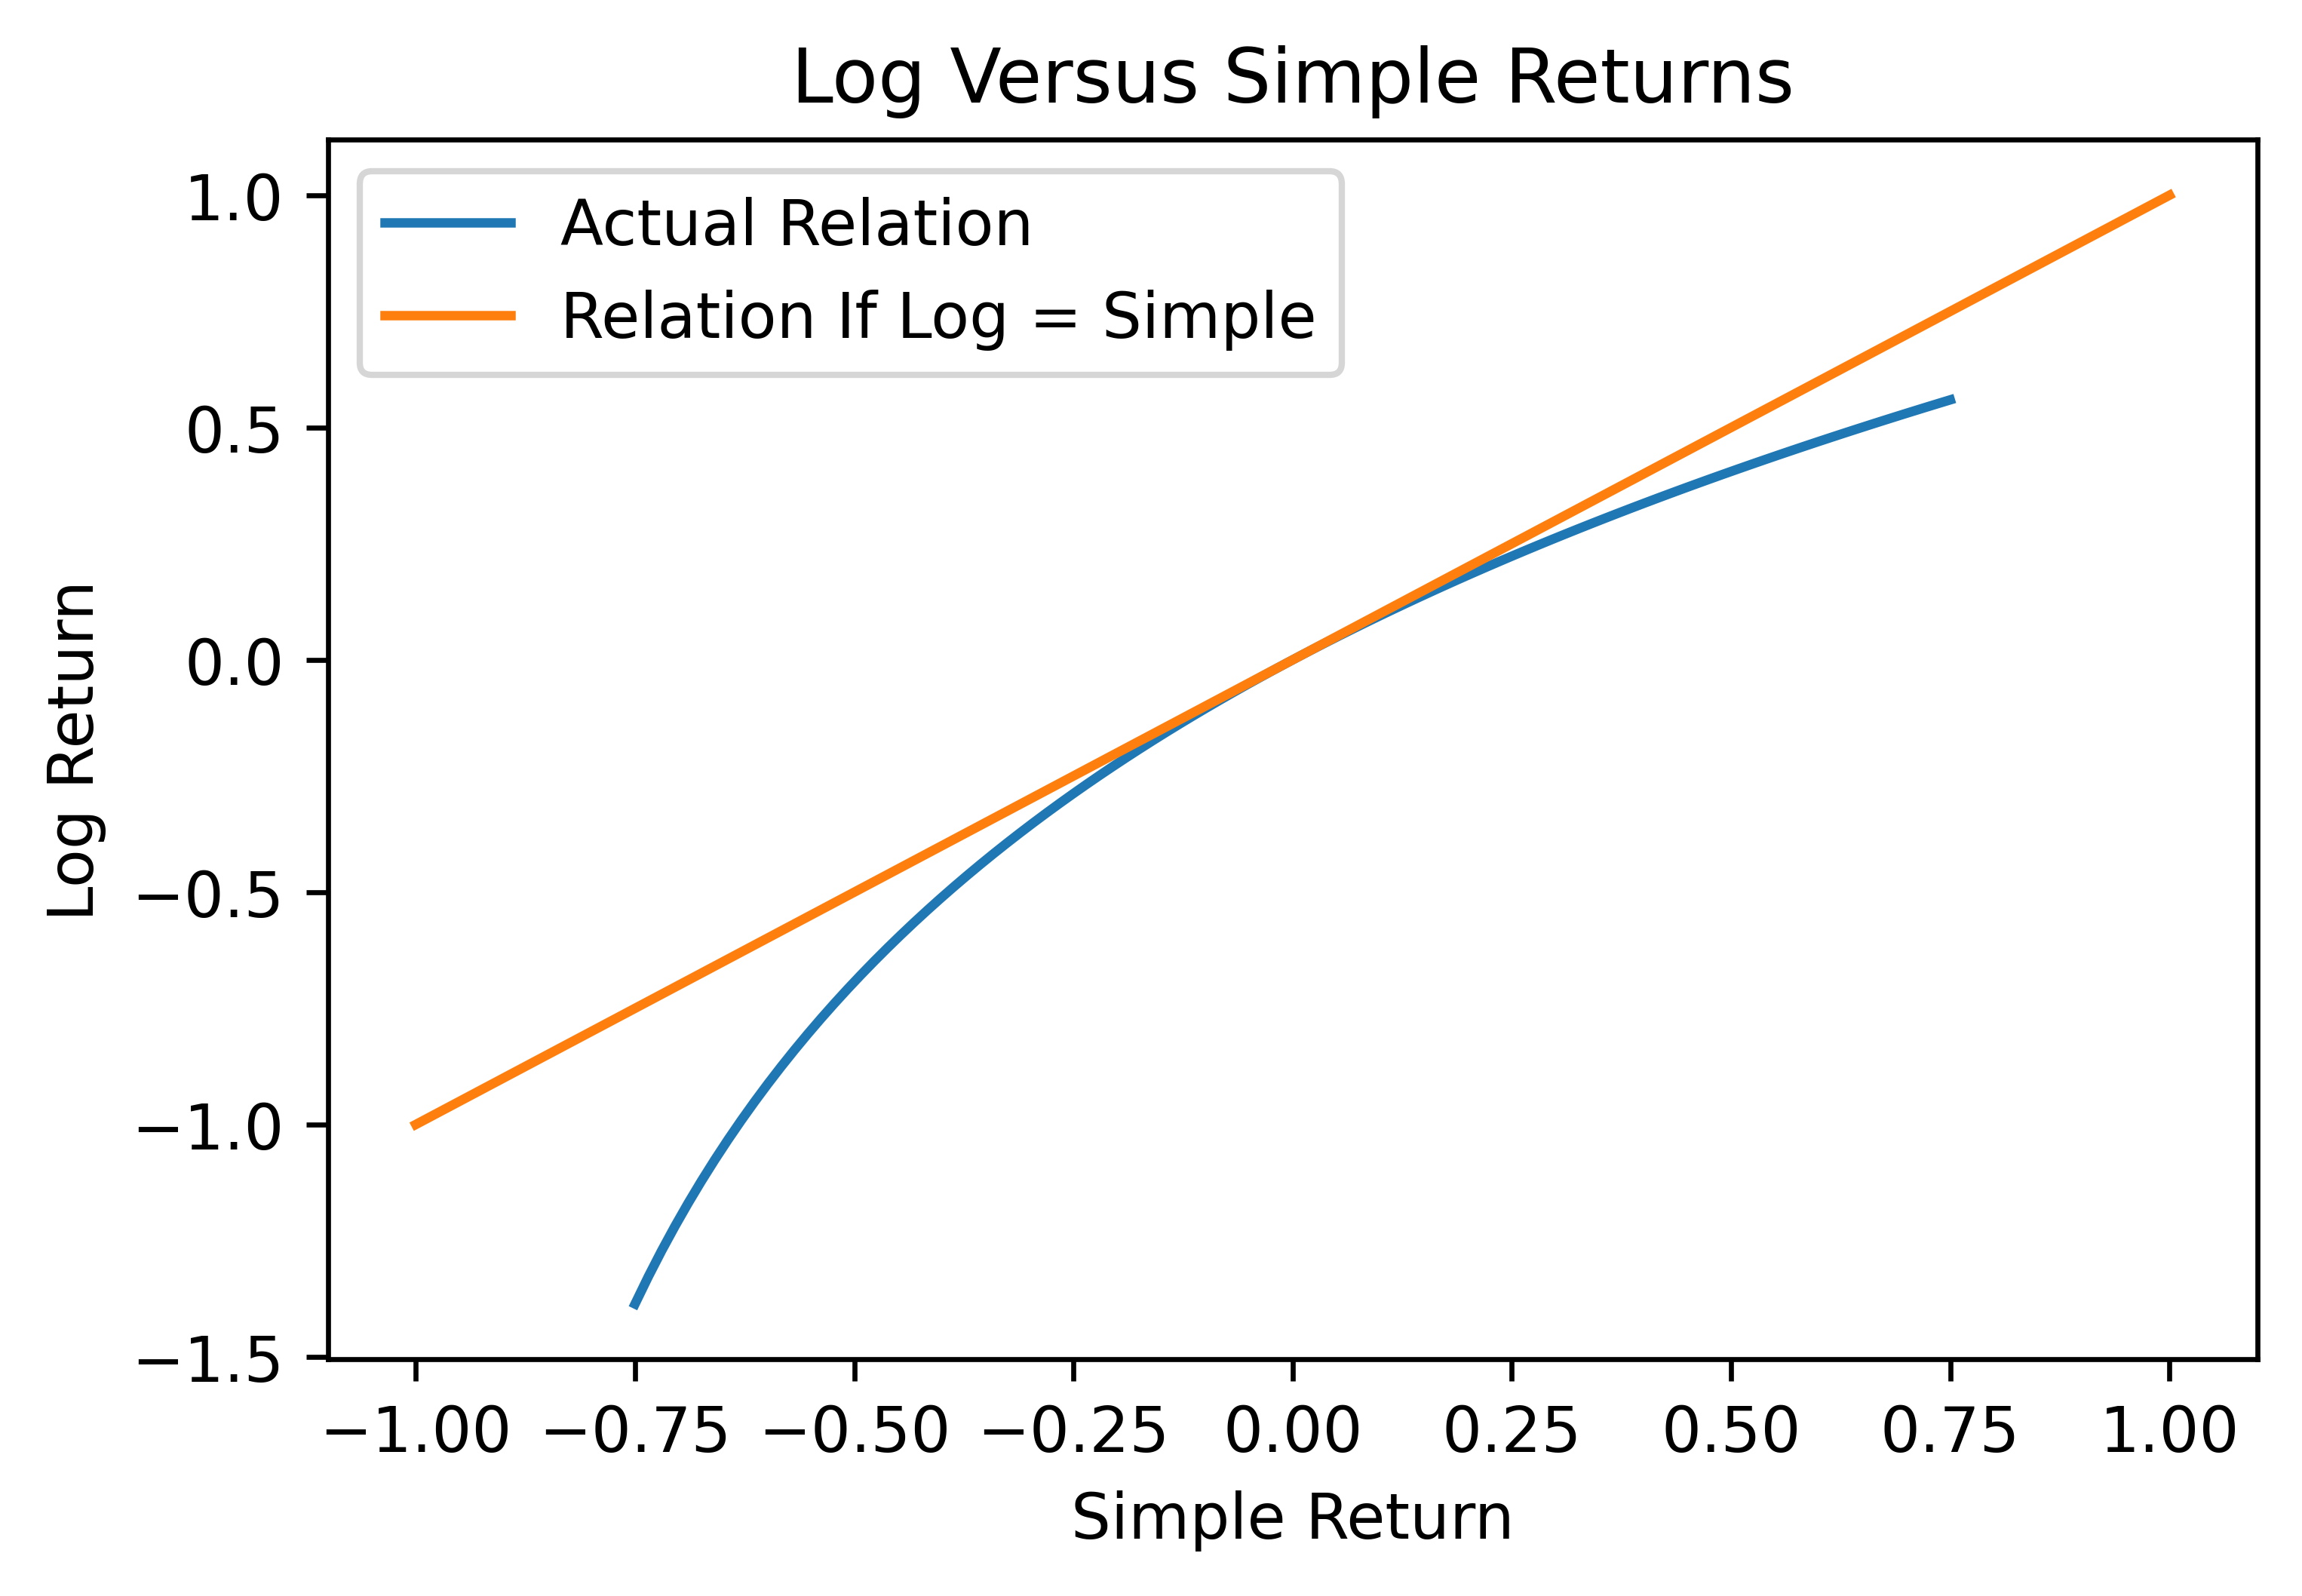

In [4]:
plt.plot(simpler, logr)
plt.plot([-1, 1], [-1, 1])
plt.xlabel('Simple Return')
plt.ylabel('Log Return')
plt.title('Log Versus Simple Returns')
plt.legend(['Actual Relation', 'Relation If Log = Simple'])
plt.show()

### Simple Return Advantage: Portfolio Calculations

For a portfolio of $N$ assets with portfolio weights $w_i$, the portfolio return $r_p$ is the weighted average of the returns of its assets: $r_p = \sum_{i=1}^N w_i r_{i}$.
For example, for an equal-weighted portfolio with two stocks, $r_p = 0.5 r_1 + 0.5 r_2 = \frac{r_1 + r_2}{2}$.
Therefore, we cannot calculate portfolio returns with log returns because the sum of logs is the log of products.
That is $\log(1+r_i) + \log(1+r_j) = \log((1+r_i) \times (1+r_j))$, which is not what we want to measure!
***We cannot perform portfolio calculations with log returns!***

### Log Return Advantage: Log Returns are Additive

We compound simple returns with multiplication, *but we compound log returns with addition.*
This additive property of log returns makes code simple, computations fast, and proofs easy when we must compound returns.

We compound returns from $t=0$ to $t=T$ as follows:
$$1 + r_{0, T} = (1 + r_1) \times (1 + r_2) \times \dots \times (1 + r_T)$$
Next, we take the log of both sides of the previous equation and use the property that the log of products is the sum of logs:
$$\log(1 + r_{0, T}) = \log((1 + r_1) \times (1 + r_2) \times \dots \times (1 + r_T)) = \log(1 + r_1) + \log(1 + r_2) + \dots + \log(1 + r_T) = \sum_{t=1}^T \log(1 + r_t)$$
Next, we exponentiate both sides of the previous equation:
$$e^{\log(1 + r_{0, T})} = e^{\sum_{t=0}^T \log(1 + r_t)}$$
Next, we use the property that $e^{\log(x)} = x$ to simplify the previous equation:
$$1 + r_{0,T} = e^{\sum_{t=0}^T \log(1 + r_t)}$$
Finally, we subtract 1 from both sides:
$$r_{0 ,T} = e^{\sum_{t=0}^T \log(1 + r_t)} - 1$$
So, the return $r_{0,T}$ from $t=0$ to $t=T$ is the exponentiated sum of log returns.
The pandas developers assume users understand the math above and focus on optimizing sums!

In [5]:
np.random.seed(42)
df = pd.DataFrame(data={'r': np.exp(np.random.randn(10_000)) - 1})

df.describe()

,r
count,10000.0000
mean,0.6529
std,2.1918
min,-0.9802
25%,-0.4896
50%,-0.0026
75%,0.9564
max,49.7158


We can time the calculation of 10-observation rolling returns.
We use `.apply()` for the simple return version because `.rolling()` does not have a product method.
We find that `.rolling()` is slower with `.apply()` than with `.sum()` by a factor of about 1,000.
***We will learn about `.rolling()` and `.apply()` in a few weeks, but they provide the best example of when to use log returns.***

In [6]:
%%timeit
df['r10_via_prod'] = (
    df['r']
    .add(1)
    .rolling(10)
    .apply(lambda x: x.prod())
    .sub(1)
)

182 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit
df['r10_via_sum'] = (
    df['r']
    .add(1)
    .pipe(np.log)
    .rolling(10)
    .sum()
    .pipe(np.exp)
    .sub(1)
)

375 μs ± 9.41 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
df.head(15)

,r,r10_via_prod,r10_via_sum
0,0.6433,NaN,NaN
1,-0.1291,NaN,NaN
2,0.9111,NaN,NaN
3,3.5861,NaN,NaN
4,-0.2088,NaN,NaN
5,-0.2087,NaN,NaN
6,3.8511,NaN,NaN
7,1.1542,NaN,NaN
8,-0.3747,NaN,NaN
9,0.7204,87.2886,87.2886


In [9]:
np.allclose(df['r10_via_prod'], df['r10_via_sum'], equal_nan=True)

True

These two approaches calculate the same return series, but the simple-return approach using `.prod()` is about 1,000 times slower than the log-return approach using `.sum()`!
***We can use log returns to calculate total returns very quickly!***

## Portfolio Math

Portfolio return $r_{p}$ is the weighted average of its asset returns, so $r_{p} = \sum_{i=1}^N w_i r_{i}$.
Here $N$ is the number of assets, $w_i$ is the weight on asset $i$, and $\sum_{i=1}^N w_i = 1$.

### The 1/N Portfolio

The $\frac{1}{N}$ portfolio equally weights portfolio assets, so $w_1 = w_2 = \dots = w_N = \frac{1}{N}$.
If $w_i = \frac{1}{N}$, then $r_{p} = \sum_{i=1}^N \frac{1}{N} r_{i} = \frac{\sum_{i=1}^N r_i}{N} = \bar{r}$.
Therefore, we can use `.mean(axis=1)` to calculate $\frac{1}{N}$ portfolio returns!

In [10]:
df2 = yf.download(tickers='AAPL AMZN GOOG MSFT NVDA TSLA', auto_adjust=False, progress=False).iloc[:-1]
returns2 = df2['Adj Close'].pct_change().dropna()

returns2.describe()

Ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
count,3678.0000,3678.0000,3678.0000,3678.0000,3678.0000,3678.0000
mean,0.0011,0.0012,0.0009,0.0010,0.0021,0.0021
std,0.0175,0.0205,0.0173,0.0162,0.0288,0.0361
min,-0.1286,-0.1405,-0.1110,-0.1474,-0.1876,-0.2106
25%,-0.0074,-0.0089,-0.0071,-0.0069,-0.0121,-0.0163
50%,0.0009,0.0010,0.0009,0.0007,0.0017,0.0012
75%,0.0102,0.0119,0.0093,0.0093,0.0161,0.0194
max,0.1198,0.1575,0.1605,0.1422,0.2981,0.2440


In [11]:
returns2.mean() # implied axis=0

Ticker
AAPL   0.0011
AMZN   0.0012
GOOG   0.0009
MSFT   0.0010
NVDA   0.0021
TSLA   0.0021
dtype: float64

In [12]:
rp2_via_mean = returns2.mean(axis=1)

rp2_via_mean

Date
2010-06-30   -0.0123
2010-07-01   -0.0107
2010-07-02   -0.0271
2010-07-06   -0.0223
2010-07-07    0.0254
               ...  
2025-02-05   -0.0128
2025-02-06    0.0069
2025-02-07   -0.0227
2025-02-10    0.0048
2025-02-11   -0.0095
Length: 3678, dtype: float64

***Note that when we apply the same portfolio weights every period, we rebalance at the same frequency as the returns data.***
If we have daily data, rebalance daily.
If we have monthly data, we rebalance monthly, and so on.

### A More General Solution

If we combine portfolio weights into vector $w$ and the time series of asset returns into matrix $\mathbf{R}$, then we can calculate the time series of portfolio returns as $r_p = w^T \mathbf{R}$.
The pandas version of this calculation is `R.dot(w)`, where `R` is a data frame of asset returns and `w` is a series or an array of portfolio weights.
We can use this approach to calculate $\frac{1}{N}$ portfolio returns, too.

In [13]:
weights2 = np.ones(returns2.shape[1]) / returns2.shape[1]

weights2

array([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667])

In [14]:
rp2_via_dot = returns2.dot(weights2)

rp2_via_dot

Date
2010-06-30   -0.0123
2010-07-01   -0.0107
2010-07-02   -0.0271
2010-07-06   -0.0223
2010-07-07    0.0254
               ...  
2025-02-05   -0.0128
2025-02-06    0.0069
2025-02-07   -0.0227
2025-02-10    0.0048
2025-02-11   -0.0095
Length: 3678, dtype: float64

Both approaches give the same answer!

In [15]:
np.allclose(rp2_via_mean, rp2_via_dot, equal_nan=True)

True

### Portfolio Math Application 1: All stocks half the time or half stocks all the time?

Are you better off investing:

1. 100% in stocks 50% of the time and the riskless asset the other 50% of the time *or*
2. 50% in stocks and 50% in the riskless asset 100% of the time?

Here is a roadmap for convincing yourself with data!

#### Download *annual* market and risk-free asset returns from Kenneth French's data library

#### Convert these factors to decimal returns and calculate the market return series

#### Add a portfolio return series that is half stocks all the time

You might call this portfolio return series `Balanced`

#### Add a portfolio return series that switches between stocks and bills every year with stocks in odd years

You might call this portfolio return series `Switching Stocks Odd`

#### Add a portfolio return series that switches between stocks and bills every year with stocks in even years

You might call this portfolio return series `Switching Stocks Even`

#### Plot the cumulative returns calculate the summary statistics for the `Balanced` and `Switching` series

Use the `.describe()` method to calcualte summary statistics.

#### Which strategy do you prefer?

Why?
How sure are you?

#### Use the `simulate()` function to simulate 10,000 different outcomes for the U.S. market

`simulate()` calculates one `Switching` return series because the randomization also randomizes the odd-year and even-year choice.

In [16]:
def simulate(df, cols=['Mkt', 'RF'], n_iter=10_000):
    """
    Simulates resampling of the given DataFrame columns and computes bal;anced and switching portfolio returns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    cols (list): List of column names to sample.
    n_iter (int): Number of iterations for simulation.

    Returns:
    pd.DataFrame: A concatenated DataFrame with simulation results.
    """
    return pd.concat(
        objs=[(
            df[cols]
            .sample(frac=1, ignore_index=True, random_state=i)
            .assign(
                Balanced=lambda x: x[cols].mean(axis=1),
                Switching=lambda x: np.where(x.index % 2 == 0, x[cols[0]], x[cols[1]])
            )
        ) for i in range(n_iter)],
        keys=range(n_iter),
        names=['Simulation', 'Year']
    )

#### Calculate the summary statistics for these new `Balanced` and `Switching` series

#### Which strategy do you prefer?

Why?
How sure are you?

### Portfolio Math Application 2: What are the benefits of diversification?

Use random portfolios of S&P 100 stocks of various portfolio sizes to show that portfolio volatility falls quickly, then slowly, then not at all as we increase portfolio size.

#### Download daily data for the stocks in the S\&P 100

Wikipedia provides tickers for the stocks in the [S\&P 100](https://en.wikipedia.org/wiki/S%26P_100).
Use a list comprehension to replace `.` in tickers with `-` for compatability with Yahoo! Finance.

#### Calculate the past five years of dailty returns for these stocks

#### Calculate the volatilies of 20 equal-weighted random portfolios of various portfolio sizes

Random portfolios should have portfolio sizes of 1, 2, 4, 6, 8, 10, 20, 30, 40, or 50 stocks each.

You can combine the `.sample(n=?, axis=1, random_state=?)`, `.mean(axis=1)`, and `.std()` to calculate the volatilities of equal-weighted portfolios.
You can collect these volatilies in a list of lists built with two `for` loops or list comprehensions.
Replace the `?`s in `.sample()` with loop counters.
The inner loop will calculate a portfolio volatilty for each portfolio size, and the outer loop will collect 20 versions of each portfolio.
Using the outer loop counter for `random_state=` makes your analysis repeatable!

#### Combine this list of list into a data frame

#### Calculate the mean volatility for each portfolio size and replicate the plot above